In [1]:
import torch
import torch.nn as nn
import torch.optim as optim
import torchvision.transforms as transforms
import torchvision.datasets as datasets

device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')

## Loading CIFAR-10
CIFAR-10 is a popular image dataset with ten classes. Our objective is to predict one of the following classes for each input image

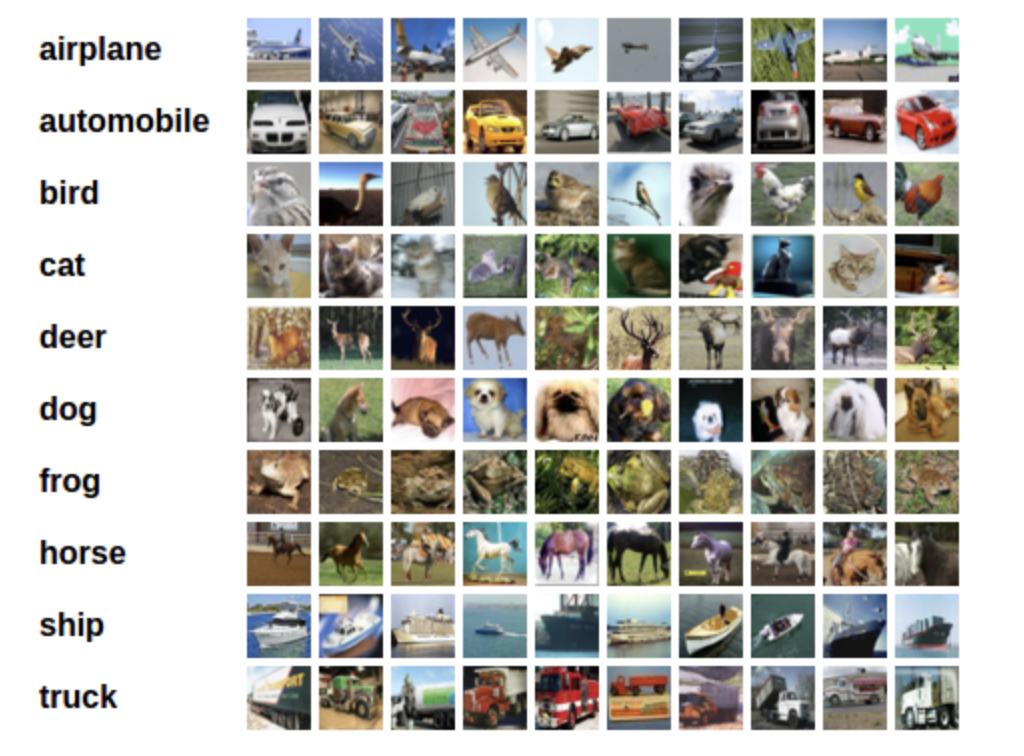

In [7]:
transform = transforms.Compose([
    transforms.ToTensor(),
    transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225]),
])

train_dataset = datasets.CIFAR10(root='./data', train=True, download=True, transform=transform)
test_dataset = datasets.CIFAR10(root='./data', train=False, download=True, transform=transform)

Files already downloaded and verified
Files already downloaded and verified


In [8]:
train_loader = torch.utils.data.DataLoader(train_dataset, batch_size=128, shuffle=True, num_workers=4)
test_loader = torch.utils.data.DataLoader(test_dataset, batch_size=128, shuffle=False, num_workers=4)

In [9]:
class Teacher(nn.Module):
  def __init__(self, num_classes=10):
    super().__init__()
    self.convs = nn.Sequential(
        nn.Conv2d(3, 128, kernel_size=3, padding=1),
        nn.ReLU(),
        nn.Conv2d(128, 64, kernel_size=3, padding=1),
        nn.ReLU(),
        nn.MaxPool2d(kernel_size=2, stride=2),
        nn.Conv2d(64, 64, kernel_size=3, padding=1),
        nn.ReLU(),
        nn.Conv2d(64, 32, kernel_size=3, padding=1),
        nn.ReLU(),
        nn.MaxPool2d(kernel_size=2, stride=2)
    )

    self.classifier = nn.Sequential(
        nn.Linear(2048, 512),
        nn.ReLU(),
        nn.Dropout(0.1),
        nn.Linear(512, num_classes)
    )
  def forward(self, x):
    x = self.convs(x)
    x = torch.flatten(x, 1)
    x = self.classifier(x)
    return x

In [10]:
class Student(nn.Module):
  def __init__(self, num_classes=10):
    super().__init__()
    self.convs = nn.Sequential(
        nn.Conv2d(3, 16, kernel_size=3, padding=1),
        nn.ReLU(),
        nn.MaxPool2d(kernel_size=2, stride=2),
        nn.Conv2d(16, 16, kernel_size=3, padding=1),
        nn.ReLU(),
        nn.MaxPool2d(kernel_size=2, stride=2)
    )
    self.classifier = nn.Sequential(
        nn.Linear(1024, 256),
        nn.ReLU(),
        nn.Dropout(0.1),
        nn.Linear(256, num_classes)
    )
  def forward(self, x):
    x = self.convs(x)
    x = torch.flatten(x, 1)
    x = self.classifier(x)
    return x

In [11]:
def train(model, train_loader, learning_rate, epochs, device):
  criterion = nn.CrossEntropyLoss()
  optimizer = optim.Adam(model.parameters(), lr=learning_rate)
  model.train()
  for epoch in range(epochs):
    running_loss = 0.0
    for input, label in train_loader:
      input, label = input.to(device), label.to(device)
      optimizer.zero_grad()

      output = model(input)
      loss = criterion(output, label)
      loss.backward()
      optimizer.step()

      running_loss += loss.item()

    print(f"Epoch {epoch+1}/{epochs}, Loss: {running_loss/len(train_loader)}")

def test(model, data_loader, device):
  model.to(device)
  model.eval()
  correct = 0
  total = 0
  with torch.no_grad():
    for input, label in data_loader:
      input, label = input.to(device), label.to(device)
      outputs = model(input)
      predict_idxs  = torch.max(outputs, 1)[1]
      total += label.size(0)
      correct += (predict_idxs == label).sum().item()
  acc = 100 * correct / total
  print(f"Accuracy: {acc}")
  return acc

In [12]:
torch.manual_seed(42)
student_alone = Student().to(device)
torch.manual_seed(42)
student_study = Student().to(device)
#ensure we have created a copy of first network
print(torch.norm(student_alone.convs[0].weight).item())
print(torch.norm(student_study.convs[0].weight).item())

2.327361822128296
2.327361822128296


In [14]:
LR = 0.001
EPOCHS = 10
train(student_alone, train_loader, LR, EPOCHS, device)

Epoch 1/10, Loss: 1.4674062750223653
Epoch 2/10, Loss: 1.153517952203141
Epoch 3/10, Loss: 1.0236048189270528
Epoch 4/10, Loss: 0.9227132102107758
Epoch 5/10, Loss: 0.8481250594339103
Epoch 6/10, Loss: 0.7805374261668271
Epoch 7/10, Loss: 0.7144733000441891
Epoch 8/10, Loss: 0.657226022018496
Epoch 9/10, Loss: 0.6039661023470447
Epoch 10/10, Loss: 0.5563145192992657


In [15]:
teacher_model = Teacher().to(device)
train(teacher_model, train_loader, LR, 10, device)

Epoch 1/10, Loss: 1.3909473596021646
Epoch 2/10, Loss: 0.8862613213946448
Epoch 3/10, Loss: 0.6763337321598512
Epoch 4/10, Loss: 0.5452589438394513
Epoch 5/10, Loss: 0.41836366625240695
Epoch 6/10, Loss: 0.31191340340372853
Epoch 7/10, Loss: 0.22967738557197248
Epoch 8/10, Loss: 0.179609581694731
Epoch 9/10, Loss: 0.14068382716430422
Epoch 10/10, Loss: 0.12415253834994248


In [16]:
def test(model, data_loader, device):
  model.to(device)
  model.eval()
  correct = 0
  total = 0
  with torch.no_grad():
    for input, label in data_loader:
      input, label = input.to(device), label.to(device)
      outputs = model(input)
      predict_idxs  = torch.max(outputs, 1)[1]
      total += label.size(0)
      correct += (predict_idxs == label).sum().item()
  acc = 100 * correct / total
  print(f"Accuracy: {acc}")
  return acc

In [17]:
test(teacher_model, test_loader, device)

Accuracy: 75.68


75.68

In [18]:
test(student_alone, test_loader, device)

Accuracy: 70.58


70.58

In [19]:
import torch.nn.functional as F
def train_KD(teacher_model, student_model, train_loader, learning_rate, epochs, T, ce_weight, kl_weight, device):
  ce_loss = nn.CrossEntropyLoss()
  optimizer = optim.Adam(student_model.parameters(), lr=learning_rate)

  teacher_model.eval()
  student_model.train()

  for epoch in range(epochs):
    running_loss = 0.0
    for input, label in train_loader:
      input, label = input.to(device), label.to(device)
      optimizer.zero_grad()

      with torch.no_grad():
        teacher_output = teacher_model(input)

      student_output = student_model(input)
      soft_output = F.log_softmax(student_output / T, dim=-1)
      soft_target = F.softmax(teacher_output / T, dim=-1)

      kl_loss = torch.sum(soft_target * (soft_target.log() - soft_output))\
                  / soft_output.size()[0] * (T**2)
      ce_loss_val = ce_loss(student_output, label)

      loss = ce_weight * ce_loss_val + kl_weight * kl_loss

      loss.backward()
      optimizer.step()

      running_loss += loss.item()

    print(f"Epoch {epoch + 1}, Loss: {running_loss / len(train_loader)}")

In [22]:
train_KD(teacher_model, student_study, train_loader, LR, 20, T=2, ce_weight=0.75, kl_weight=0.25, device='cuda')

Epoch 1, Loss: 0.7992444035342282
Epoch 2, Loss: 0.7285320678025561
Epoch 3, Loss: 0.6799133379593529
Epoch 4, Loss: 0.6259946015942127
Epoch 5, Loss: 0.5873077812097262
Epoch 6, Loss: 0.5439952060847026


KeyboardInterrupt: 

In [23]:
test(student_study, test_loader, device)

Accuracy: 71.09


71.09

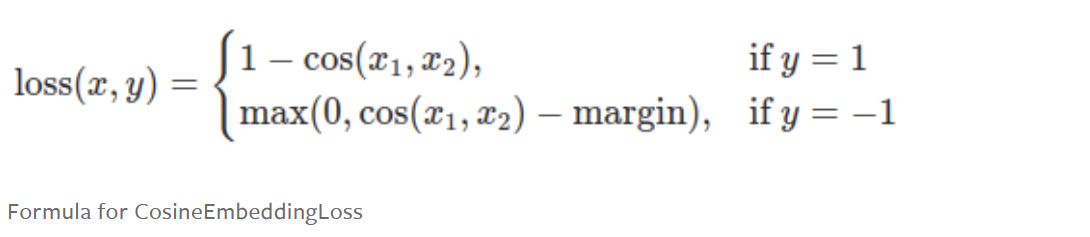

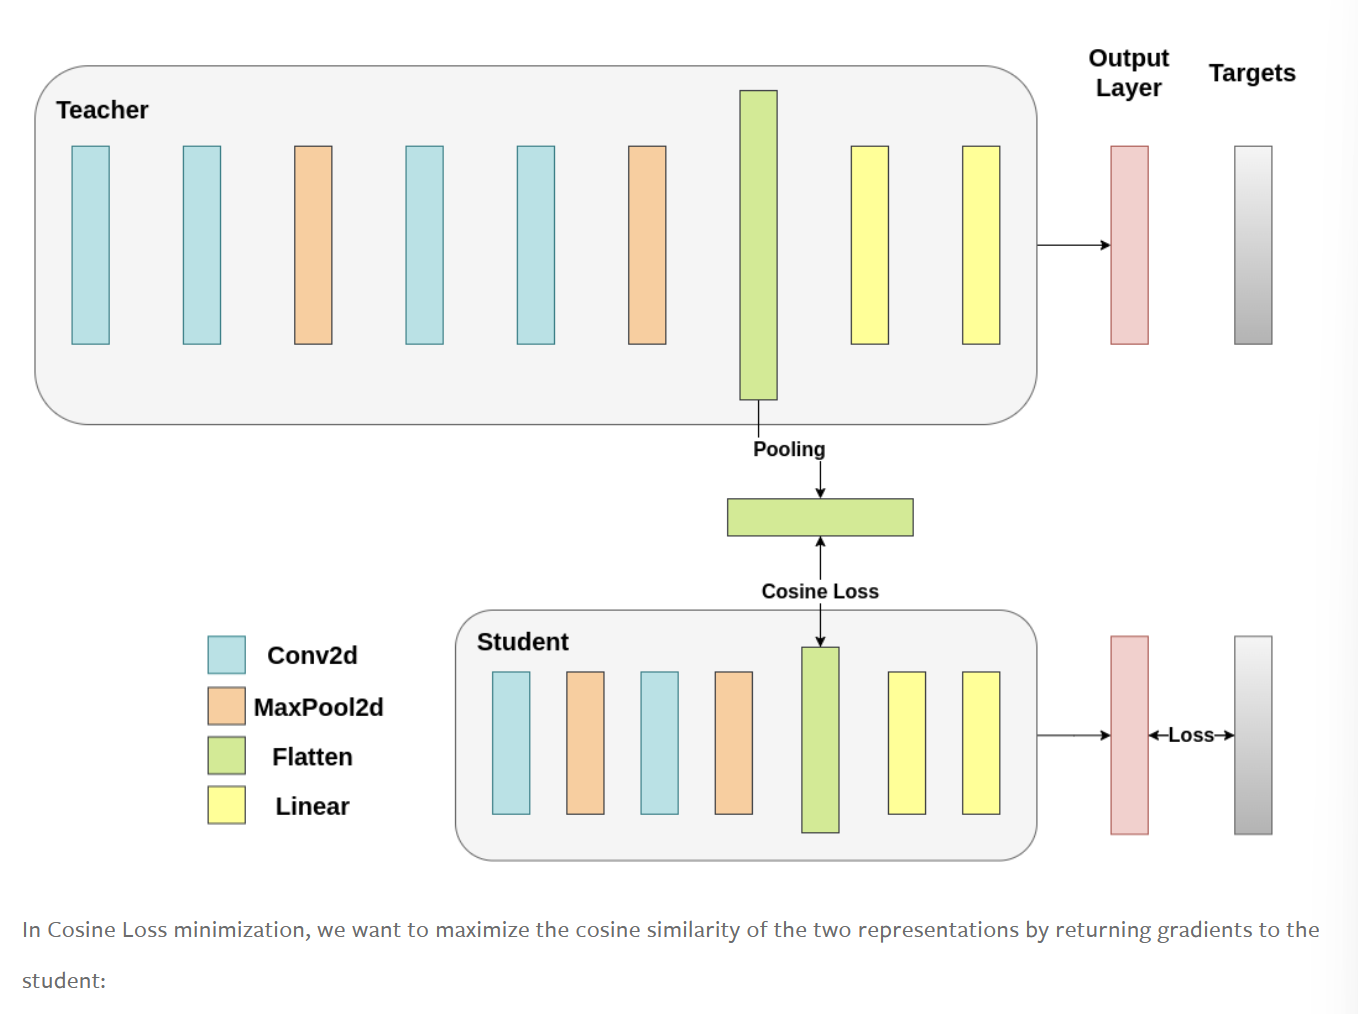

In [26]:
tensor = torch.rand(1, 10)
torch.nn.functional.avg_pool1d(tensor, 2)

tensor([[0.5299, 0.5587, 0.4769, 0.8246, 0.8213]])

In [36]:
class TeacherCosine(nn.Module):
  def __init__(self, num_classes=10):
    super().__init__()
    self.convs = nn.Sequential(
        nn.Conv2d(3, 128, kernel_size=3, padding=1),
        nn.ReLU(),
        nn.Conv2d(128, 64, kernel_size=3, padding=1),
        nn.ReLU(),
        nn.MaxPool2d(kernel_size=2, stride=2),
        nn.Conv2d(64, 64, kernel_size=3, padding=1),
        nn.ReLU(),
        nn.Conv2d(64, 32, kernel_size=3, padding=1),
        nn.ReLU(),
        nn.MaxPool2d(kernel_size=2, stride=2)
    )

    self.classifier = nn.Sequential(
        nn.Linear(2048, 512),
        nn.ReLU(),
        nn.Dropout(0.1),
        nn.Linear(512, num_classes)
    )
  def forward(self, x):
    x = self.convs(x)
    x = torch.flatten(x, 1)
    pooling_output = F.avg_pool1d(x, 2)
    x = self.classifier(x)
    return x, pooling_output

class StudentCosine(nn.Module):
  def __init__(self, num_classes=10):
    super().__init__()
    self.convs = nn.Sequential(
        nn.Conv2d(3, 16, kernel_size=3, padding=1),
        nn.ReLU(),
        nn.MaxPool2d(kernel_size=2, stride=2),
        nn.Conv2d(16, 16, kernel_size=3, padding=1),
        nn.ReLU(),
        nn.MaxPool2d(kernel_size=2, stride=2)
    )
    self.classifier = nn.Sequential(
        nn.Linear(1024, 256),
        nn.ReLU(),
        nn.Dropout(0.1),
        nn.Linear(256, num_classes)
    )
  def forward(self, x):
    x = self.convs(x)
    flatten_output = torch.flatten(x, 1)
    x = self.classifier(flatten_output)
    return x, flatten_output

In [37]:
cosine_teacher = TeacherCosine().to(device)
cosine_teacher.load_state_dict(teacher_model.state_dict())
print(torch.norm(cosine_teacher.convs[0].weight).item())
print(torch.norm(teacher_model.convs[0].weight).item())

7.557990550994873
7.557990550994873


In [38]:
torch.manual_seed(42)
cosine_student = StudentCosine().to(device)
print(torch.norm(cosine_student.convs[0].weight).item())

2.327361822128296


In [40]:
sample = torch.randn(10, 3, 32, 32).to(device)

logit_student, hidden_student = cosine_student(sample)
logit_teacher, hidden_teacher = cosine_teacher(sample)
print(logit_student.shape, hidden_student.shape)
print(logit_teacher.shape, hidden_teacher.shape)

torch.Size([10, 10]) torch.Size([10, 1024])
torch.Size([10, 10]) torch.Size([10, 1024])


In [41]:
def train_cosine(teacher, student, train_loader, epochs, learning_rate, hidden_weight, ce_weight, device):
  optimizer = torch.optim.Adam(student.parameters(), lr=learning_rate)
  ce_loss = nn.CrossEntropyLoss()
  cosine_loss = nn.CosineEmbeddingLoss()

  teacher.eval()
  student.train()
  for epoch in range(epochs):
    running_loss = 0.0
    for input, label in train_loader:
      input, label = input.to(device), label.to(device)
      optimizer.zero_grad()
      with torch.no_grad():
        _, hidden_teacher = teacher(input)

      logit_student, hidden_student = student(input)
      ce_loss_val = ce_loss(logit_student, label)
      cosine_loss_val = cosine_loss(hidden_student, hidden_teacher, target=torch.ones(input.shape[0]).to(device))
      loss = ce_weight * ce_loss_val + hidden_weight * cosine_loss_val

      loss.backward()
      optimizer.step()
      running_loss += loss.item()

    print(f"Epoch {epoch+1} loss: {running_loss/len(train_loader)}")


In [42]:
train_cosine(cosine_teacher, cosine_student, train_loader, 10, 0.001, 0.2, 0.8, device)

/usr/local/lib/python3.10/dist-packages/torch/utils/data/dataloader.py:558: UserWarning: This DataLoader will create 4 worker processes in total. Our suggested max number of worker in current system is 2, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  warnings.warn(_create_warning_msg(


Epoch 1 loss: 1.3361498687578284
Epoch 2 loss: 1.0872529280155212
Epoch 3 loss: 0.9759524051490647
Epoch 4 loss: 0.8978747269686531
Epoch 5 loss: 0.8414227018880722
Epoch 6 loss: 0.7902654843866977
Epoch 7 loss: 0.7452041802503874
Epoch 8 loss: 0.7102805558982712
Epoch 9 loss: 0.6728049272771381
Epoch 10 loss: 0.6345053548398225


In [43]:
def test(model, data_loader, device):
  model.to(device)
  model.eval()
  correct = 0
  total = 0
  with torch.no_grad():
    for input, label in data_loader:
      input, label = input.to(device), label.to(device)
      outputs, _ = model(input)
      predict_idxs  = torch.max(outputs, 1)[1]
      total += label.size(0)
      correct += (predict_idxs == label).sum().item()
  acc = 100 * correct / total
  print(f"Accuracy: {acc}")
  return acc

In [44]:
test(cosine_student, test_loader, device)

/usr/local/lib/python3.10/dist-packages/torch/utils/data/dataloader.py:558: UserWarning: This DataLoader will create 4 worker processes in total. Our suggested max number of worker in current system is 2, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  warnings.warn(_create_warning_msg(


Accuracy: 70.45


70.45

In [45]:
conv_student = cosine_student.convs(sample)
conv_teacher = cosine_teacher.convs(sample)

In [46]:
print(conv_student.shape)
print(conv_teacher.shape)

torch.Size([10, 16, 8, 8])
torch.Size([10, 32, 8, 8])


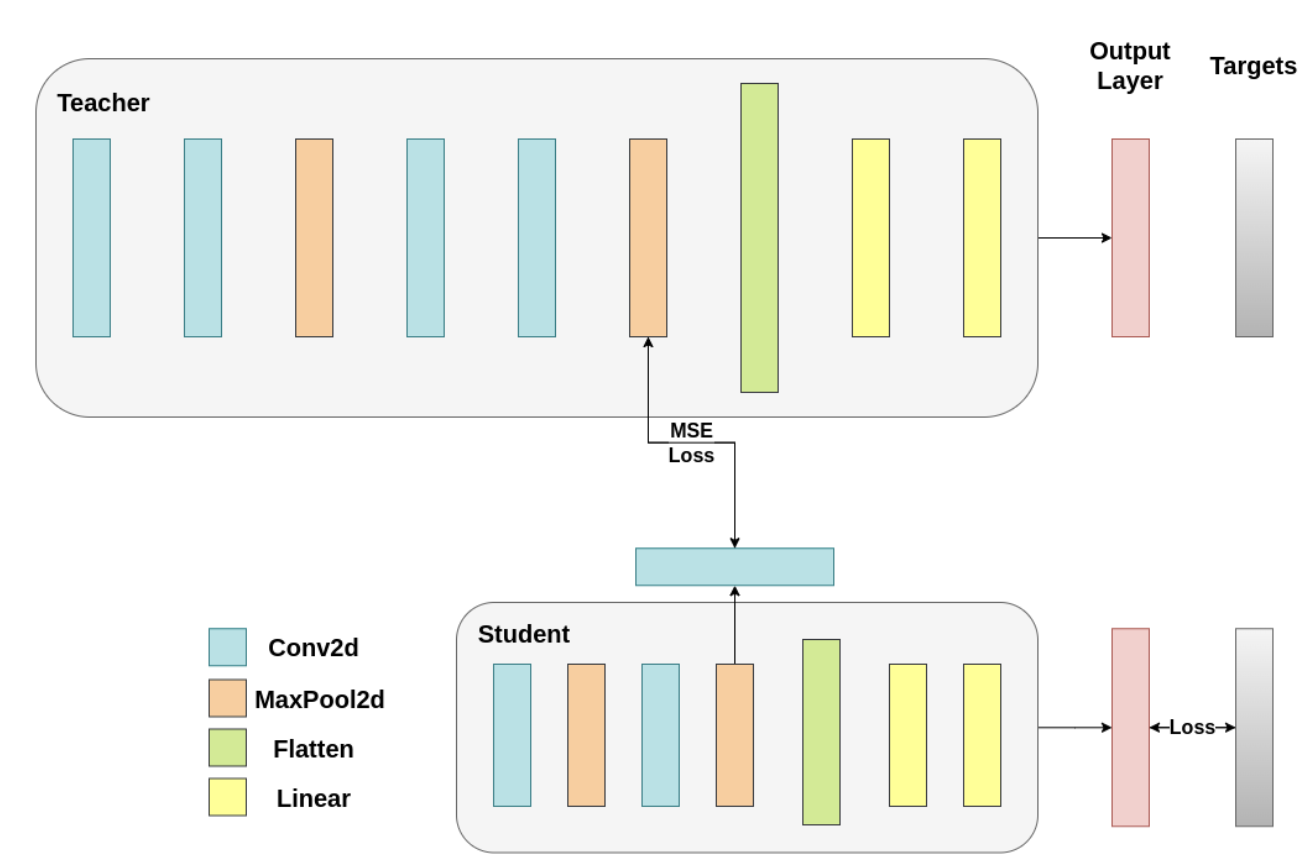

In [47]:
class TeacherRegression(nn.Module):
  def __init__(self, num_classes=10):
    super().__init__()
    self.convs = nn.Sequential(
        nn.Conv2d(3, 128, kernel_size=3, padding=1),
        nn.ReLU(),
        nn.Conv2d(128, 64, kernel_size=3, padding=1),
        nn.ReLU(),
        nn.MaxPool2d(kernel_size=2, stride=2),
        nn.Conv2d(64, 64, kernel_size=3, padding=1),
        nn.ReLU(),
        nn.Conv2d(64, 32, kernel_size=3, padding=1),
        nn.ReLU(),
        nn.MaxPool2d(kernel_size=2, stride=2)
    )

    self.classifier = nn.Sequential(
        nn.Linear(2048, 512),
        nn.ReLU(),
        nn.Dropout(0.1),
        nn.Linear(512, num_classes)
    )
  def forward(self, x):
    x = self.convs(x)
    conv_feature = x
    x = torch.flatten(x, 1)
    x = self.classifier(x)
    return x, conv_feature

class StudentRegression(nn.Module):
  def __init__(self, num_classes=10):
    super().__init__()
    self.convs = nn.Sequential(
        nn.Conv2d(3, 16, kernel_size=3, padding=1),
        nn.ReLU(),
        nn.MaxPool2d(kernel_size=2, stride=2),
        nn.Conv2d(16, 16, kernel_size=3, padding=1),
        nn.ReLU(),
        nn.MaxPool2d(kernel_size=2, stride=2)
    )
    self.classifier = nn.Sequential(
        nn.Linear(1024, 256),
        nn.ReLU(),
        nn.Dropout(0.1),
        nn.Linear(256, num_classes)
    )
    self.regression = nn.Conv2d(16, 32, kernel_size=3, padding=1)
  def forward(self, x):
    x = self.convs(x)
    regression_output = self.regression(x)
    x = torch.flatten(x, 1)
    x = self.classifier(x)
    return x, regression_output

In [48]:
def train_mse_loss(teacher, student, train_loader, epochs, learning_rate, feature_weight, ce_weight, device):
  mse_loss = nn.MSELoss()
  ce_loss = nn.CrossEntropyLoss()
  optimizer = torch.optim.Adam(student.parameters(), lr=learning_rate)

  teacher.eval()
  student.train()
  for epoch in range(epochs):
    running_loss = 0.0
    for input, target in train_loader:
      input, target = input.to(device), target.to(device)
      optimizer.zero_grad()
      with torch.no_grad():
        _, teacher_features = teacher(input)

      student_output, student_features = student(input)
      hidden_loss = mse_loss(student_features, teacher_features)
      ce_loss_val = ce_loss(student_output, target)
      loss = feature_weight * hidden_loss + ce_weight * ce_loss_val
      loss.backward()
      optimizer.step()

      running_loss += loss.item()
    print(f"Epoch {epoch+1}/{epochs}, Loss: {running_loss/len(train_loader)}")

In [49]:
torch.manual_seed(42)
mse_teacher = TeacherRegression().to(device)
mse_teacher.load_state_dict(teacher_model.state_dict())

print(torch.norm(mse_teacher.convs[0].weight).item())
print(torch.norm(teacher_model.convs[0].weight).item())

7.557990550994873
7.557990550994873


In [50]:
mse_student = StudentRegression().to(device)

train_mse_loss(mse_teacher, mse_student, train_loader, 10, 0.001, 0.2, 0.8, device)

/usr/local/lib/python3.10/dist-packages/torch/utils/data/dataloader.py:558: UserWarning: This DataLoader will create 4 worker processes in total. Our suggested max number of worker in current system is 2, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  warnings.warn(_create_warning_msg(


Epoch 1/10, Loss: 1.613647885029883
Epoch 2/10, Loss: 1.258000236338057
Epoch 3/10, Loss: 1.1189989721988474
Epoch 4/10, Loss: 1.0205121040344238
Epoch 5/10, Loss: 0.9479310300648974
Epoch 6/10, Loss: 0.8853029256586529
Epoch 7/10, Loss: 0.8401794772013984
Epoch 8/10, Loss: 0.7912637653863034
Epoch 9/10, Loss: 0.7429043595748179
Epoch 10/10, Loss: 0.7032031560188059


In [51]:
test(mse_student, test_loader, device)

/usr/local/lib/python3.10/dist-packages/torch/utils/data/dataloader.py:558: UserWarning: This DataLoader will create 4 worker processes in total. Our suggested max number of worker in current system is 2, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  warnings.warn(_create_warning_msg(


Accuracy: 70.64


70.64